# Tusk Sampling

This notebook contains a program for estimating the probability that, given a population of $2N$ tusks drawn from $N$ elephants, and sampling $k$ of the tusks, there are $n$ unique elephants in your sample.

The user only has to run the cells containing the function definitions, then, in the section marked 'Run Here', specify the values of $N$, $M$ and $D$: $N$ is the number of elephants, $M$ is the number of simulations to run, and $D$ is the number of elephants you'd like to sample (for example, you may want one fifth of the possible 1000 elephants, in which case you set $N$ = 1000, $D$ = 200). Then, call the function called do_all. This will perform the simulation and return a plot that shows how the number of elephants you've sampled ($y$ axis) increases as you take take samples from more and more of the tusks ($x$ axis). The purple line shows the number of tusks recommended to sample $D$ elephants. This recommendation is made by finding the first number of tusks for which the average number of elephants sampled is at least $D$.

You may change your mind after the simulation is done, and want to look at how many tusks are required for a different value of $D$. In this case, just call plotter(analysed, D): This creates the same plot as above, but running it this way means you don't have to do the simulation again. 

Finally, you may want to know what the possibility of undersampling the elephants by some margin if you draw the recommended number of tusks. From what I've seen, the simulation mean is usually a robust estimate of how many tusks you get (in that it's very unlikely you go far from the mean in any direction), so this step is optional. I've provided 95% confidence intervals around the mean in the main plot, but you can get richer information by calling get_hist(res, k, bins = 20), where $k$ is some number of tusks sampled. This returns a histogram showing how often the simulation ended up with different numbers of elephants after drawing $k$ tusks. From this you can look to see whether it's likely that you end up with far too few elephants, in which case you may way want to sample a few more tusks for peace of mind. 

Performing the simulation takes some time (it took about 5 minutes for me to run 10,000 simulations). I recommend doing at least 10,000 simulations. If you're doing very large numbers of elephants (>1000), I recommend adding an extra 10000 sims per 1000 elephants over 1000.

The only requirements are Numpy, Pandas, and Matplotlib. I wrote this in Python 2.7, but believe it will also work if run in Python 3.x

Help is happily given at niksmather@gmail.com 

## Function definitions

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

In [3]:
def create_tusk_population(N):
    """Creates an array of tuples (i, j), where i is an integer \leq N, and
    j is either 0 or 1, representing the first or second tusk of the ith elephant"""
    
    pop =[]
    
    for i in range(N):
        pop.append((i,0))
        pop.append((i,1))
    
    return pop

In [4]:
def simulate_one(pop):
    """given a population pop, takes samples one by one, and tells you how many you unique elephants you have sampled
    up to that point. Output is array of cumulative counts"""
    count = 0
    cum = []
    sampled = set()
    two_N = len(pop)    
    indices = np.random.choice(np.array([i for i in range(two_N)]), size = two_N, replace = False)
    for i in indices:
        chosen_el = pop[i][0] #first element of pop signifies the elephant.
        sampled.add(chosen_el)
        count = len(sampled)
        cum.append(count)
    return cum

In [5]:
def simulate_all(N, M):
    """Performs M simulations from a population of N elephants (2N tusks).
    Output is a pandas dataframe with columns m and rows k which shows,
    for simulation m, how many elephants have been sampled after k tusks have been drawn"""
    pop = create_tusk_population(N)
    
    first = simulate_one(pop)
    res = pd.DataFrame(first)
    
    for i in range(M-1):
        new = simulate_one(pop)
        res[i+1] = new
    
    res.index = res.index + 1
    
    return res

In [6]:
def analyse(res,bound = 0.95):
    """Given the dataframe from simulate_all, returns a dataframe where the rows correspond to
    tusks sampled, and the columns show the mean and 95% confidence interval"""
    
    means = res.mean(axis=1)
    analysed = pd.DataFrame(means, index = res.index)
    
    
    def get_conf_bound(row,bound = 0.95, which = 'upper'):
        """lower confidence bound for elephants sampled, given the empirical distribution in row. 
        bound is desired  bounding quantile"""
        row = np.array(row)
        row.sort()
        rev = row[::-1] #reverse the row to get lower bounds as well


        M = len(row)
        threshold = floor(bound*M)
        
        if which =='upper':
            return row[threshold]
        else:       
            return rev[threshold]

    analysed['lower_bound'] = res.apply(lambda s: get_conf_bound(s, bound, 'lower' ), axis = 1)
    analysed['upper_bound'] = res.apply(lambda s: get_conf_bound(s, bound, 'upper' ), axis = 1)
    
    analysed.columns = ['Mean', 'Lower 95% Confidence Bound', 'Upper 95% Confidence Bound']
    
    return analysed

        

In [7]:
def plotter(analysed, D, tags = True):
        
    analysed.plot(figsize = [10,7])
    plt.ylabel('Number of unique elephants sampled')
    plt.xlabel('Tusks Sampled')
    
    mean = analysed['Mean']
    recommend = mean[mean >= D].index[0]
    
    line_up_y = np.linspace(0, D)
    line_up_x = [recommend for i in range(len(line_up_y))]
    
    line_cross_x = np.linspace(0, recommend)
    line_cross_y = [D for i in range(len(line_up_y))]
    
    plt.plot(line_cross_x, line_cross_y, linestyle = '-.', c = 'purple')
    plt.plot(line_up_x, line_up_y, linestyle = '-.', c= 'purple')
    
    if tags == True:
        plt.text(recommend + 10, 0, '%s tusks recommended' % recommend, bbox = dict(facecolor='purple', alpha=0.5))

        plt.text(0, D + 10, '%s elephants required' % D, bbox = dict(facecolor='purple', alpha=0.5))
        
    else:
        plt.text(recommend + 10, 0, '%s' % recommend, bbox = dict(facecolor='purple', alpha=0.5))

        plt.text(0, D + 10, '%s' % D, bbox = dict(facecolor='purple', alpha=0.5))
        
        
    return

In [8]:
def do_all(N,M, bound=0.95):
    """Puts all of the above in one function"""
    res = simulate_all(N, M)
    res.to_csv('./Elephant_Sim_1000_elephants_10k_Sims.csv', index = False)
    analysed = analyse(res, bound)

    plotter(analysed, D)
    
    
    return res, analysed

In [9]:
def get_hist(res, k, bins = 10):
    res.loc[k].hist(bins = bins)
    return

# Run here

In [23]:
N = 1000 #Specify the number of elephants in your sample
M = 10000 #Specify the number of simulations to run. The more the better, but running more will take longer. 
D = 5 #The number of unique elephants you desire to be in your sample.

C:\ProgramData\Miniconda2\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Miniconda2\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


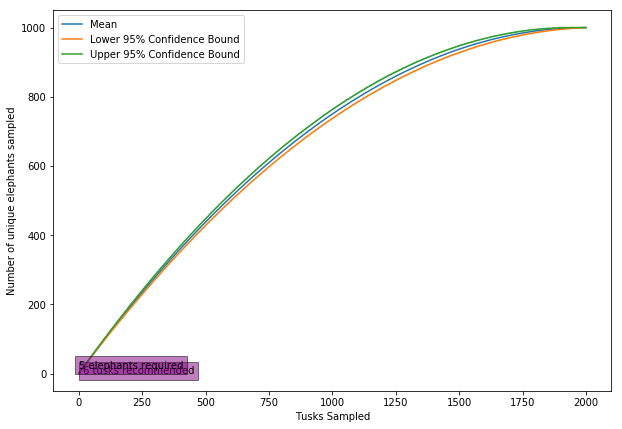

In [24]:
### This runs the simulation ####
#### This will be slow #####

res, analysed = do_all(N, M)

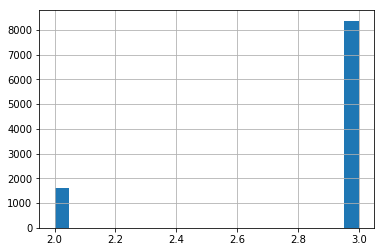

In [16]:
"""Gives a histogram showing how often the simulation returned 
a certain number of elephants (x-axis) after sampling k tusks
"""
# Change the bins argument to alter how much resolution is shown in the histogram
get_hist(res, k =3, bins = 21) 



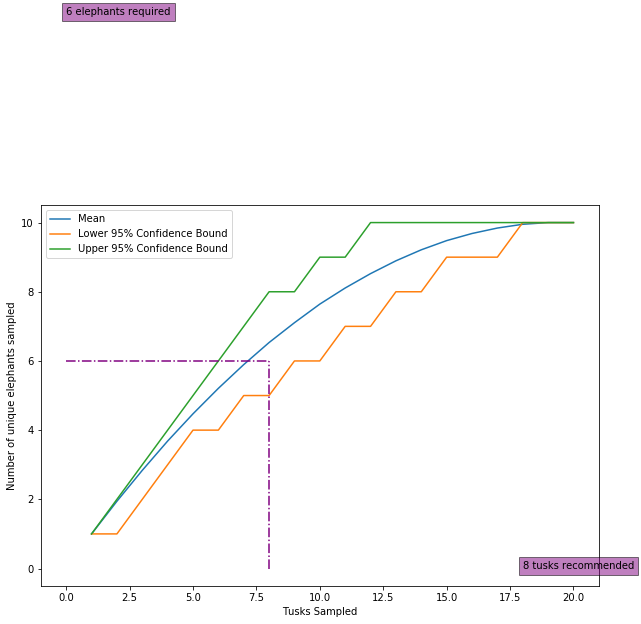

In [17]:
plotter(analysed, D = 6) #Use this to look at what's required to find different numbers of elephants, without redoing the sim.

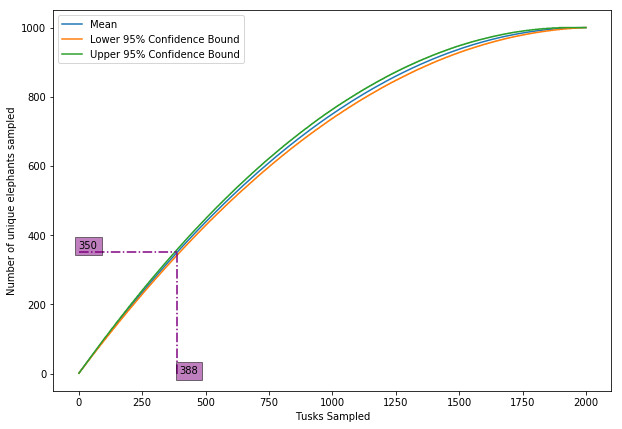

In [102]:
# If the text gets in the way, you can run the above with tags = False
plotter(analysed, D = 350, tags = False)
